In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import AlgoLoop
import StatisticFunc

plt.style.use('Solarize_Light2')                     # 绘图风格
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 字体雅黑
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False    # 处理负号

# 数据预处理

## 提取并处理各资产收盘价数据

In [2]:
Prices = pd.read_csv("Raw/国内资产收盘价.csv", encoding="utf_8_sig")         # 读取价格数据
Prices["日期"] = pd.DatetimeIndex(Prices["日期"])      # 类型转换
Prices = Prices.set_index("日期")                     # 设置索引

### 计算各资产日收益率

In [3]:
Returns = Prices / Prices.shift(1, axis=0) - 1        # 日间收益率
Returns = Returns.dropna(axis=0, how='all')           # 删除无数据日

### 计算各资产累计收益率

In [4]:
cumReturns = (1.0 + Returns)
cumReturns = cumReturns.fillna(1.0)                    # 填充空值
cumReturns = cumReturns.cumprod()                      # 计算各资产累计收益率

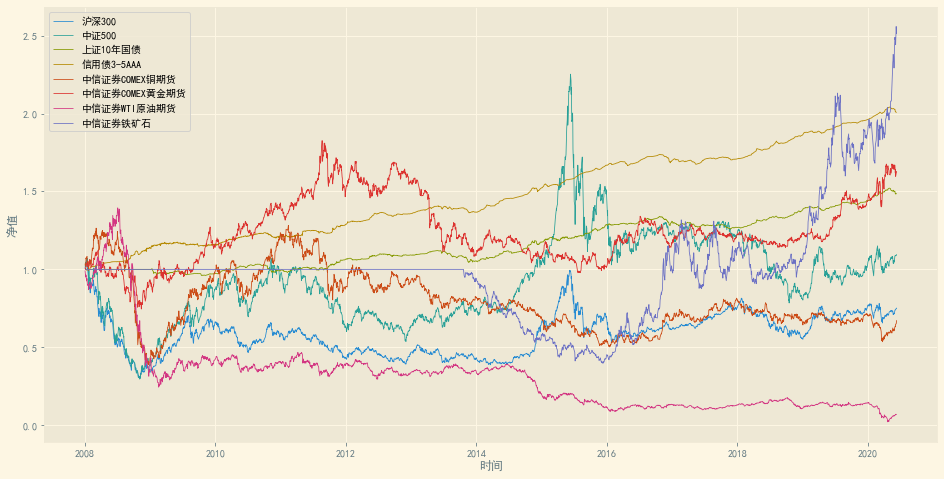

In [6]:
fig = plt.figure(figsize=(16, 8))
for col in cumReturns.columns:
    plt.plot(cumReturns.index, cumReturns[col], lw=0.8, label=col)
plt.legend(loc='best')
plt.xlabel('时间')
plt.ylabel('净值')
plt.show()

# 风险平价

**资产明细**
- 沪深300指数
- 中证500指数
- 三年期3A信用债全价指数
- 十年期国债全价指数
- COMEX铜
- COMEX黄金
- NYMEX原油
- 铁矿石期货

回溯时间：2008年初-至今

买卖单笔手续费：千1

## 权重的指数加权平均（EMA）对策略的影响

### 裸权重

#### 程序运行

In [78]:
# 运行
timeWindow = [20, 40, 60, 80, 100, 120]           # 调仓周期
initValue = 10000

NetValueDF = pd.DataFrame(index=Returns.index)
DailyPnlDF = pd.DataFrame(index=Returns.index) 
DrawDownDF = pd.DataFrame(index=Returns.index)

for dtime in timeWindow:
    tradeDF = AlgoLoop.AlgoTrade(Returns, cumReturns, dtime, up=0.2, totVal=initValue)
    NetValueDF[str(dtime)+'组合净值'] = tradeDF['投资组合净值'] / initValue  
    DailyPnlDF[str(dtime)+'组合日收益率'] = tradeDF['投资组合净值'] / tradeDF['投资组合净值'].shift(1) - 1.0
    DrawDownDF[str(dtime)+'最大回撤'] = tradeDF['最大回撤']                      

#### 回测表现汇总

In [79]:
# 汇总
summaryDF = pd.DataFrame(index=['20交易日调仓', '40交易日调仓', '60交易日调仓', 
                                '80交易日调仓', '100交易日调仓', '120交易日调仓'])

summaryDF["年平均收益率"] = DailyPnlDF.mean(axis=0).values * 250
summaryDF["年平均标准差"] = DailyPnlDF.std(axis=0).values * np.sqrt(250)
summaryDF["无基准夏普比率"] = summaryDF["年平均收益率"] / summaryDF["年平均标准差"]
summaryDF["最大回撤"] = DrawDownDF.min(axis=0).values
summaryDF

,年平均收益率,年平均标准差,无基准夏普比率,最大回撤
20交易日调仓,0.049702,0.053171,0.934757,-0.154810
40交易日调仓,0.068824,0.065970,1.043264,-0.096020
60交易日调仓,0.097158,0.071001,1.368406,-0.083864
80交易日调仓,0.069994,0.068508,1.021686,-0.101680
100交易日调仓,0.046479,0.081792,0.568256,-0.148116
120交易日调仓,0.080327,0.054103,1.484716,-0.069038


#### 各投资组合净值曲线

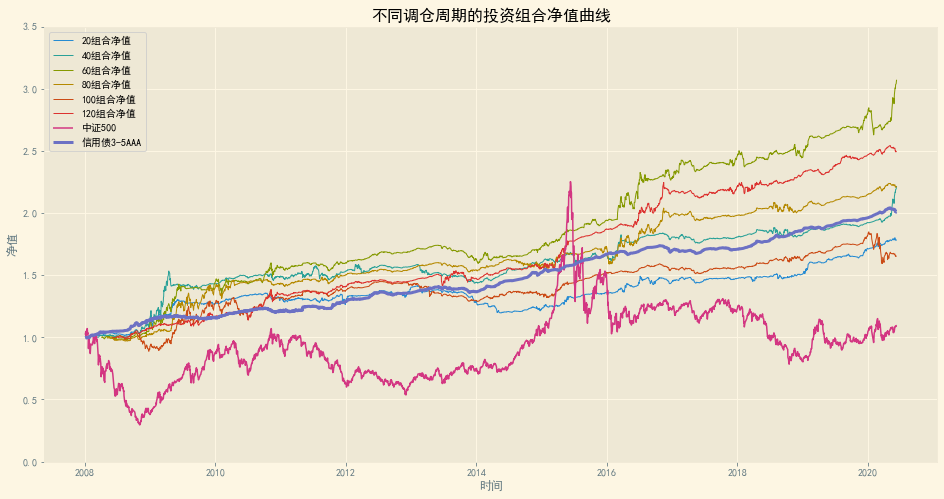

In [110]:
fig = plt.figure(figsize=(16, 8))

for col in NetValueDF.columns:
    plt.plot(NetValueDF.index, NetValueDF[col], lw=1.0, label=col)

plt.plot(cumReturns.index, cumReturns['中证500'], lw=1.5, label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], lw=3.0, label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.5)
plt.legend(loc='upper left')
plt.title('不同调仓周期的投资组合净值曲线')
plt.savefig('裸权重.jpg', dpi=200)

### EMA权重

#### 程序运行

In [90]:
# 运行
timeWindow = [20, 40, 60, 80, 100, 120]           # 调仓周期
initValue = 10000

NetValueDF_ema = pd.DataFrame(index=Returns.index)
DailyPnlDF_ema = pd.DataFrame(index=Returns.index) 
DrawDownDF_ema = pd.DataFrame(index=Returns.index)

for dtime in timeWindow:
    tradeDF = AlgoLoop.AlgoTrade(Returns, cumReturns, dtime, up=0.2, totVal=initValue, mode='ema')
    NetValueDF_ema[str(dtime)+'组合净值'] = tradeDF['投资组合净值'] / initValue  
    DailyPnlDF_ema[str(dtime)+'组合日收益率'] = tradeDF['投资组合净值'] / tradeDF['投资组合净值'].shift(1) - 1.0
    DrawDownDF_ema[str(dtime)+'最大回撤'] = tradeDF['最大回撤']                      

#### 回测表现汇总

In [91]:
# 汇总
summaryDF_ema = pd.DataFrame(index=['20交易日调仓', '40交易日调仓', '60交易日调仓', 
                                    '80交易日调仓', '100交易日调仓', '120交易日调仓'])

summaryDF_ema["年平均收益率"] = DailyPnlDF_ema.mean(axis=0).values * 250
summaryDF_ema["年平均标准差"] = DailyPnlDF_ema.std(axis=0).values * np.sqrt(250)
summaryDF_ema["无基准夏普比率"] = summaryDF_ema["年平均收益率"] / summaryDF_ema["年平均标准差"]
summaryDF_ema["最大回撤"] = DrawDownDF_ema.min(axis=0).values
summaryDF_ema

,年平均收益率,年平均标准差,无基准夏普比率,最大回撤
20交易日调仓,0.039815,0.041222,0.965873,-0.064569
40交易日调仓,0.053171,0.044749,1.188200,-0.065001
60交易日调仓,0.046860,0.044372,1.056078,-0.099783
80交易日调仓,0.046463,0.050904,0.912750,-0.120708
100交易日调仓,0.063633,0.051070,1.245998,-0.067095
120交易日调仓,0.062723,0.045149,1.389235,-0.064637


#### 各投资组合净值曲线

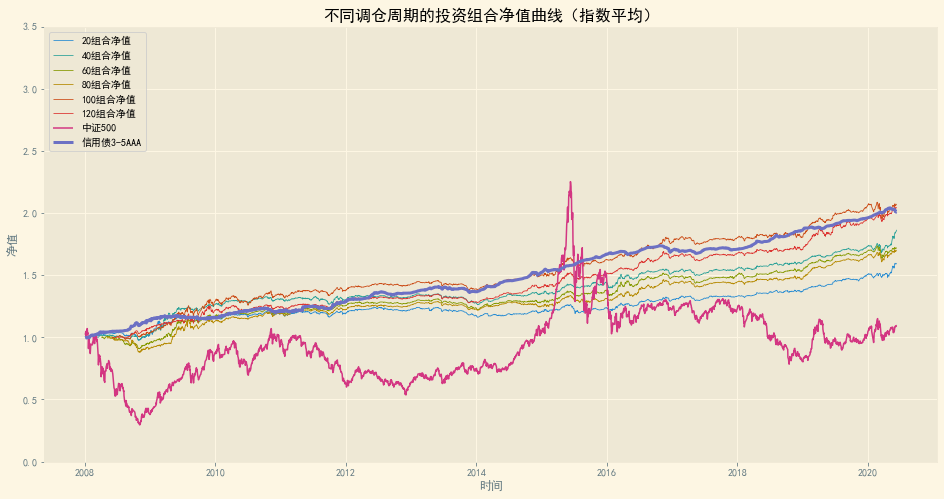

In [111]:
fig = plt.figure(figsize=(16, 8))

for col in NetValueDF_ema.columns:
    plt.plot(NetValueDF_ema.index, NetValueDF_ema[col], lw=0.8, label=col)
    
plt.plot(cumReturns.index, cumReturns['中证500'], lw=1.5, label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], lw=3.0, label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.5)
plt.legend(loc='upper left')
plt.title('不同调仓周期的投资组合净值曲线（指数平均）')
plt.savefig('指数平均权重.jpg', dpi=200)

## 寻找稳定的交易周期（裸权重）

### 程序运行

In [100]:
# 运行
timeWindow = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]           # 调仓周期
initValue = 10000

NetValueDF_plus = pd.DataFrame(index=Returns.index)
DailyPnlDF_plus = pd.DataFrame(index=Returns.index) 
DrawDownDF_plus = pd.DataFrame(index=Returns.index)

for dtime in timeWindow:
    tradeDF = AlgoLoop.AlgoTrade(Returns, cumReturns, dtime, up=0.2, totVal=initValue, mode='plain')
    NetValueDF_plus[str(dtime)+'组合净值'] = tradeDF['投资组合净值'] / initValue  
    DailyPnlDF_plus[str(dtime)+'组合日收益率'] = tradeDF['投资组合净值'] / tradeDF['投资组合净值'].shift(1) - 1.0
    DrawDownDF_plus[str(dtime)+'最大回撤'] = tradeDF['最大回撤']                      

### 回测表现汇总

In [101]:
# 汇总
summaryDF_plus = pd.DataFrame(index=['20交易日调仓', '40交易日调仓', '60交易日调仓', '80交易日调仓', '100交易日调仓', 
                                    '120交易日调仓', '140交易日调仓', '160交易日调仓', '180交易日调仓', '200交易日调仓', 
                                    '220交易日调仓', '240交易日调仓'])

summaryDF_plus["年平均收益率"] = DailyPnlDF_plus.mean(axis=0).values * 250
summaryDF_plus["年平均标准差"] = DailyPnlDF_plus.std(axis=0).values * np.sqrt(250)
summaryDF_plus["无基准夏普比率"] = summaryDF_plus["年平均收益率"] / summaryDF_plus["年平均标准差"]
summaryDF_plus["最大回撤"] = DrawDownDF_plus.min(axis=0).values
summaryDF_plus

,年平均收益率,年平均标准差,无基准夏普比率,最大回撤
20交易日调仓,0.049702,0.053171,0.934757,-0.154810
40交易日调仓,0.068824,0.065970,1.043264,-0.096020
60交易日调仓,0.097158,0.071001,1.368406,-0.083864
80交易日调仓,0.069994,0.068508,1.021686,-0.101680
100交易日调仓,0.046479,0.081792,0.568256,-0.148116
120交易日调仓,0.080327,0.054103,1.484716,-0.069038
140交易日调仓,0.025992,0.093242,0.278755,-0.356496
160交易日调仓,0.037963,0.092581,0.410047,-0.281258
180交易日调仓,0.063244,0.064673,0.977906,-0.154706
200交易日调仓,0.051328,0.068232,0.752262,-0.140192


### 各投资组合净值曲线

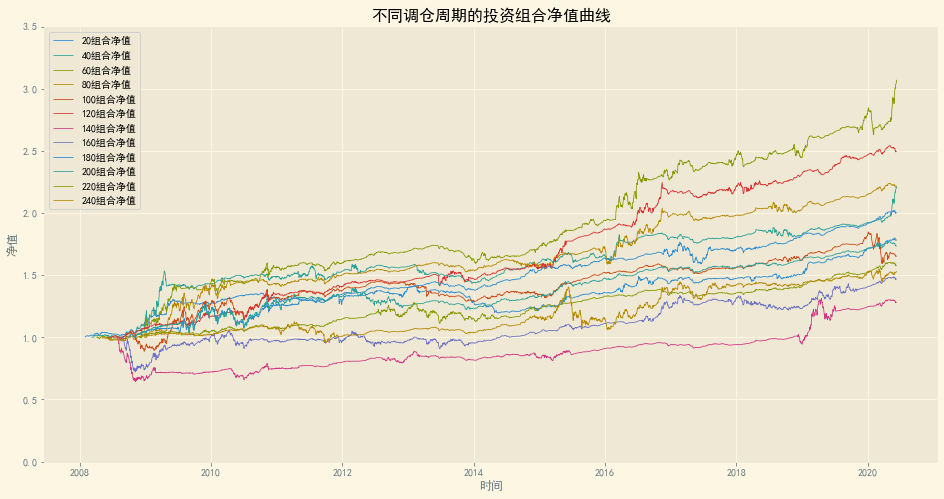

In [112]:
fig = plt.figure(figsize=(16, 8))

for col in NetValueDF_plus.columns:
    plt.plot(NetValueDF_plus.index, NetValueDF_plus[col], lw=0.8, label=col)

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.5)
plt.legend(loc='upper left')
plt.title('不同调仓周期的投资组合净值曲线')
plt.savefig('多周期.jpg', dpi=200)

### 年间收益率分布

In [114]:
yearReturns_plus = StatisticFunc.annualReturns(NetValueDF_plus)

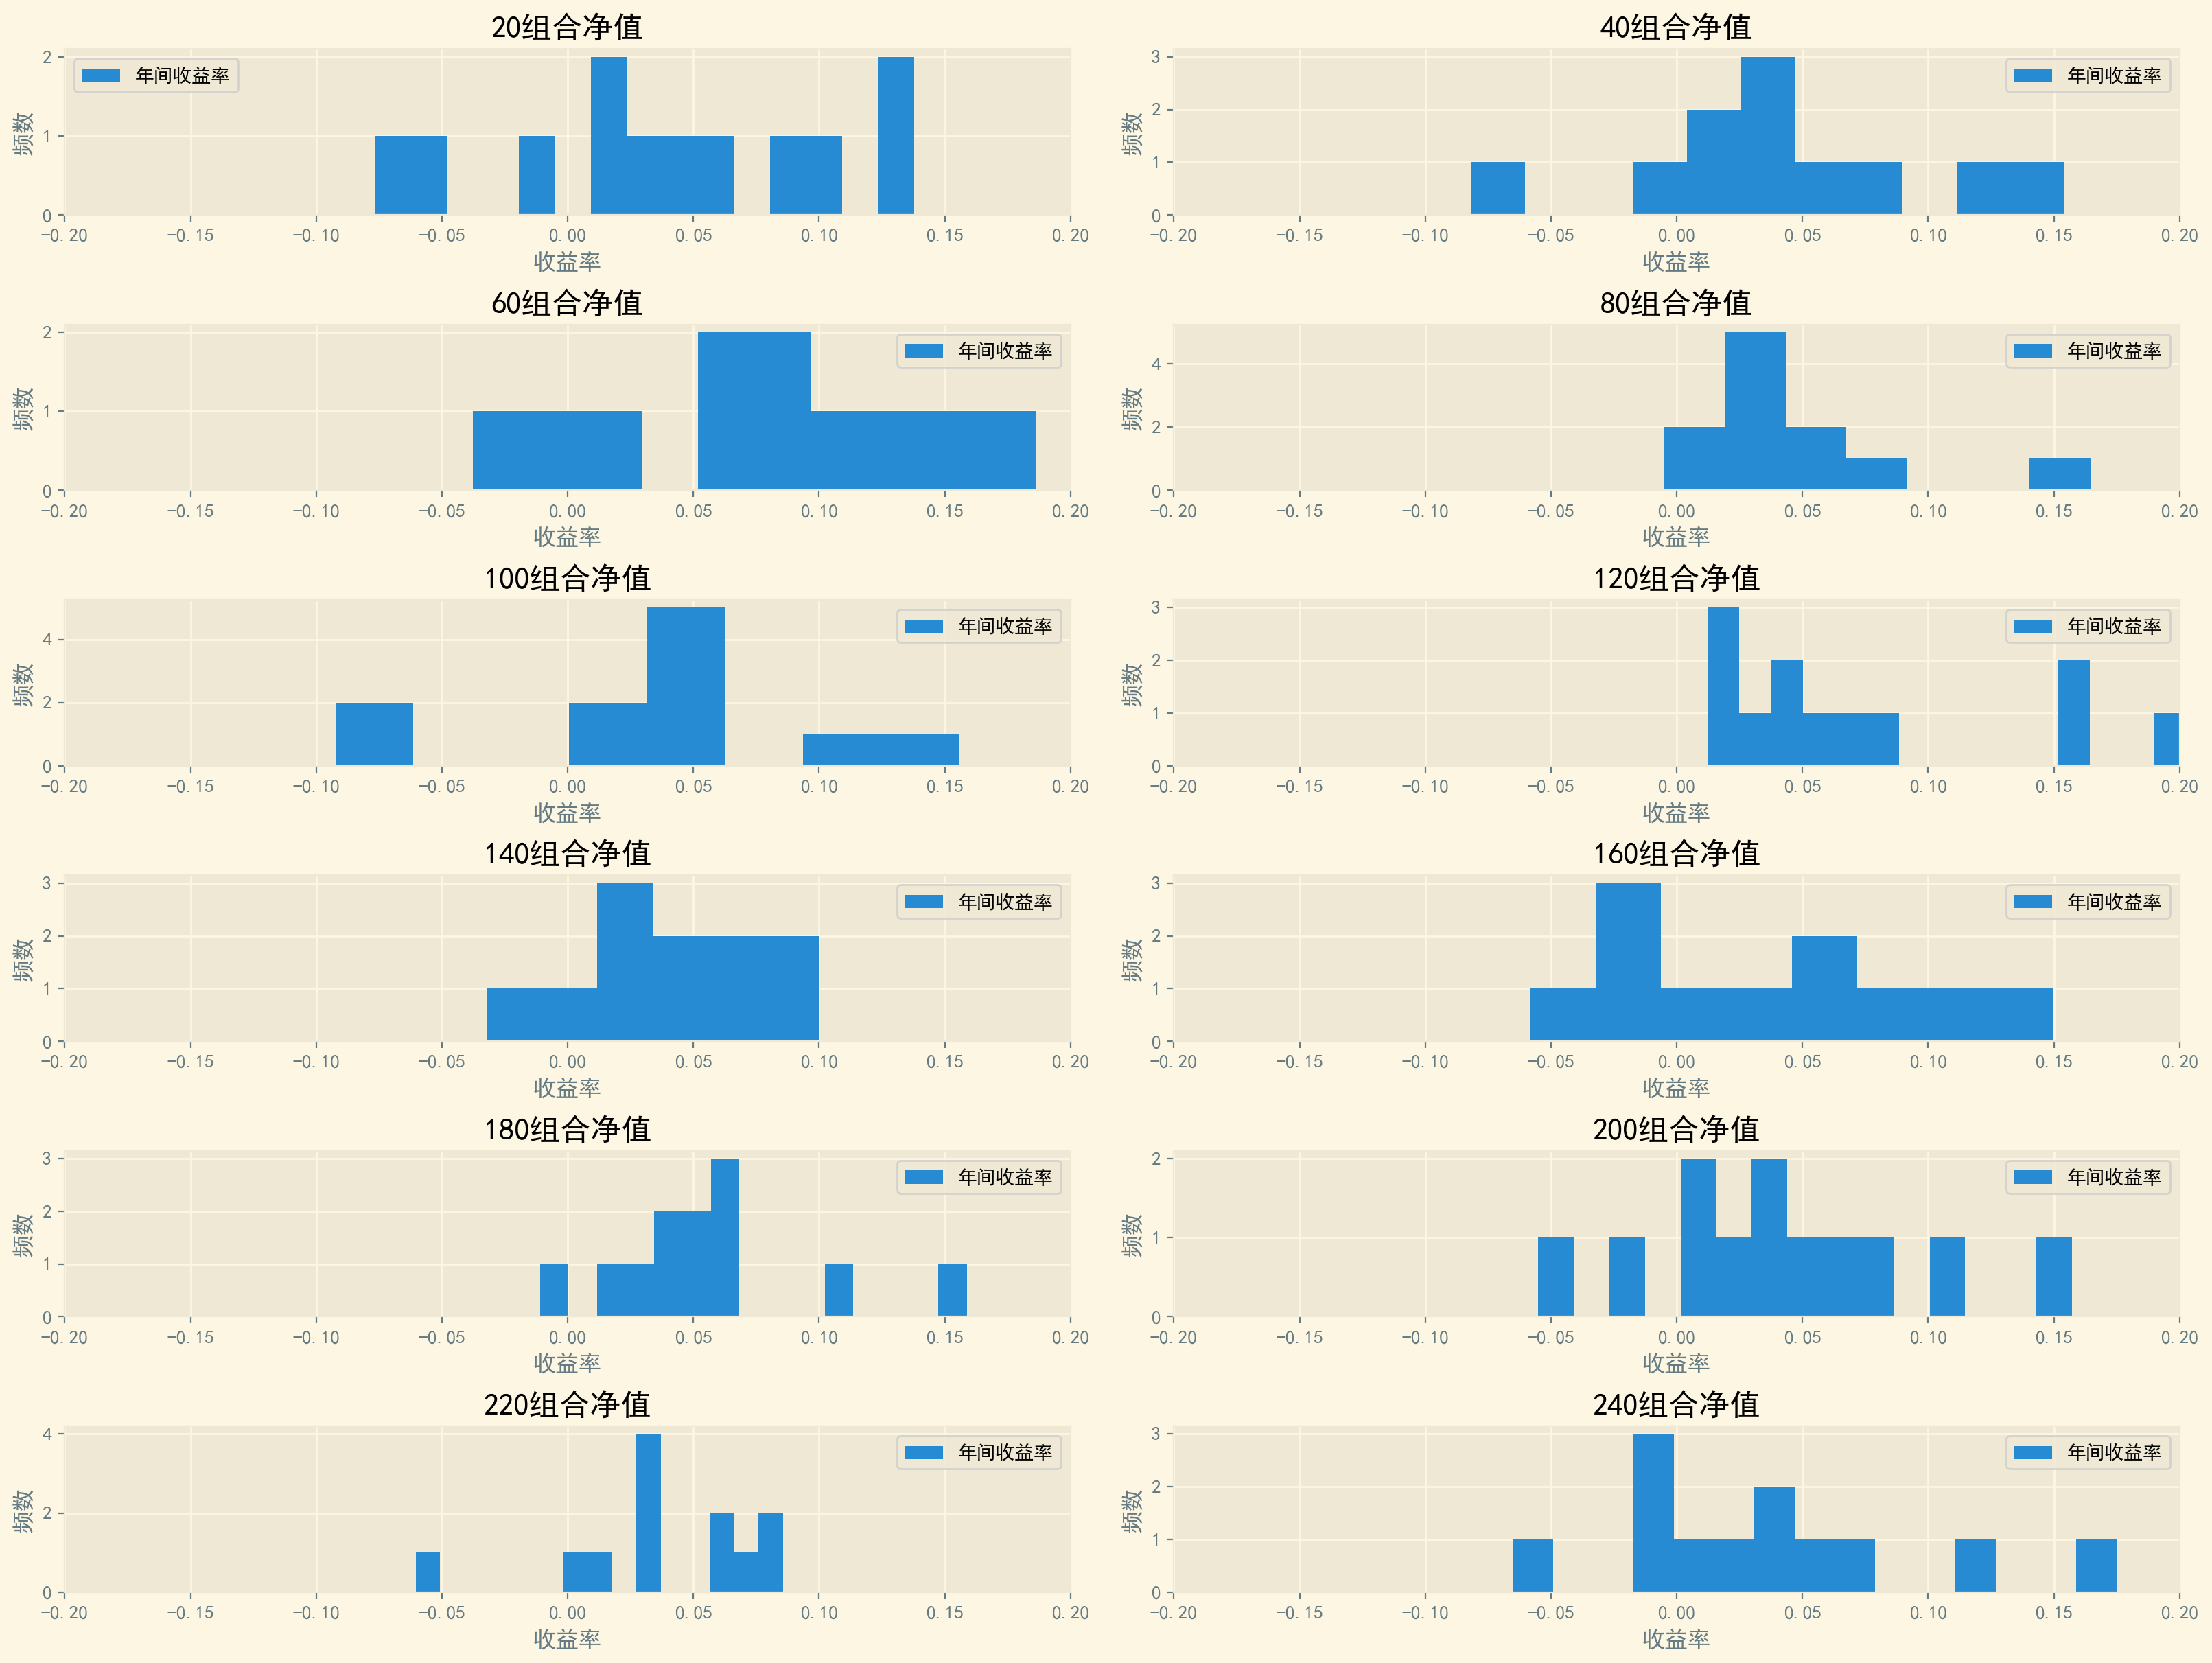

In [125]:
StatisticFunc.ReturnDist(yearReturns_plus, 2)

### 月间收益率分布

In [121]:
monthlyReturns_plus = StatisticFunc.monthlyReturns(NetValueDF_plus)

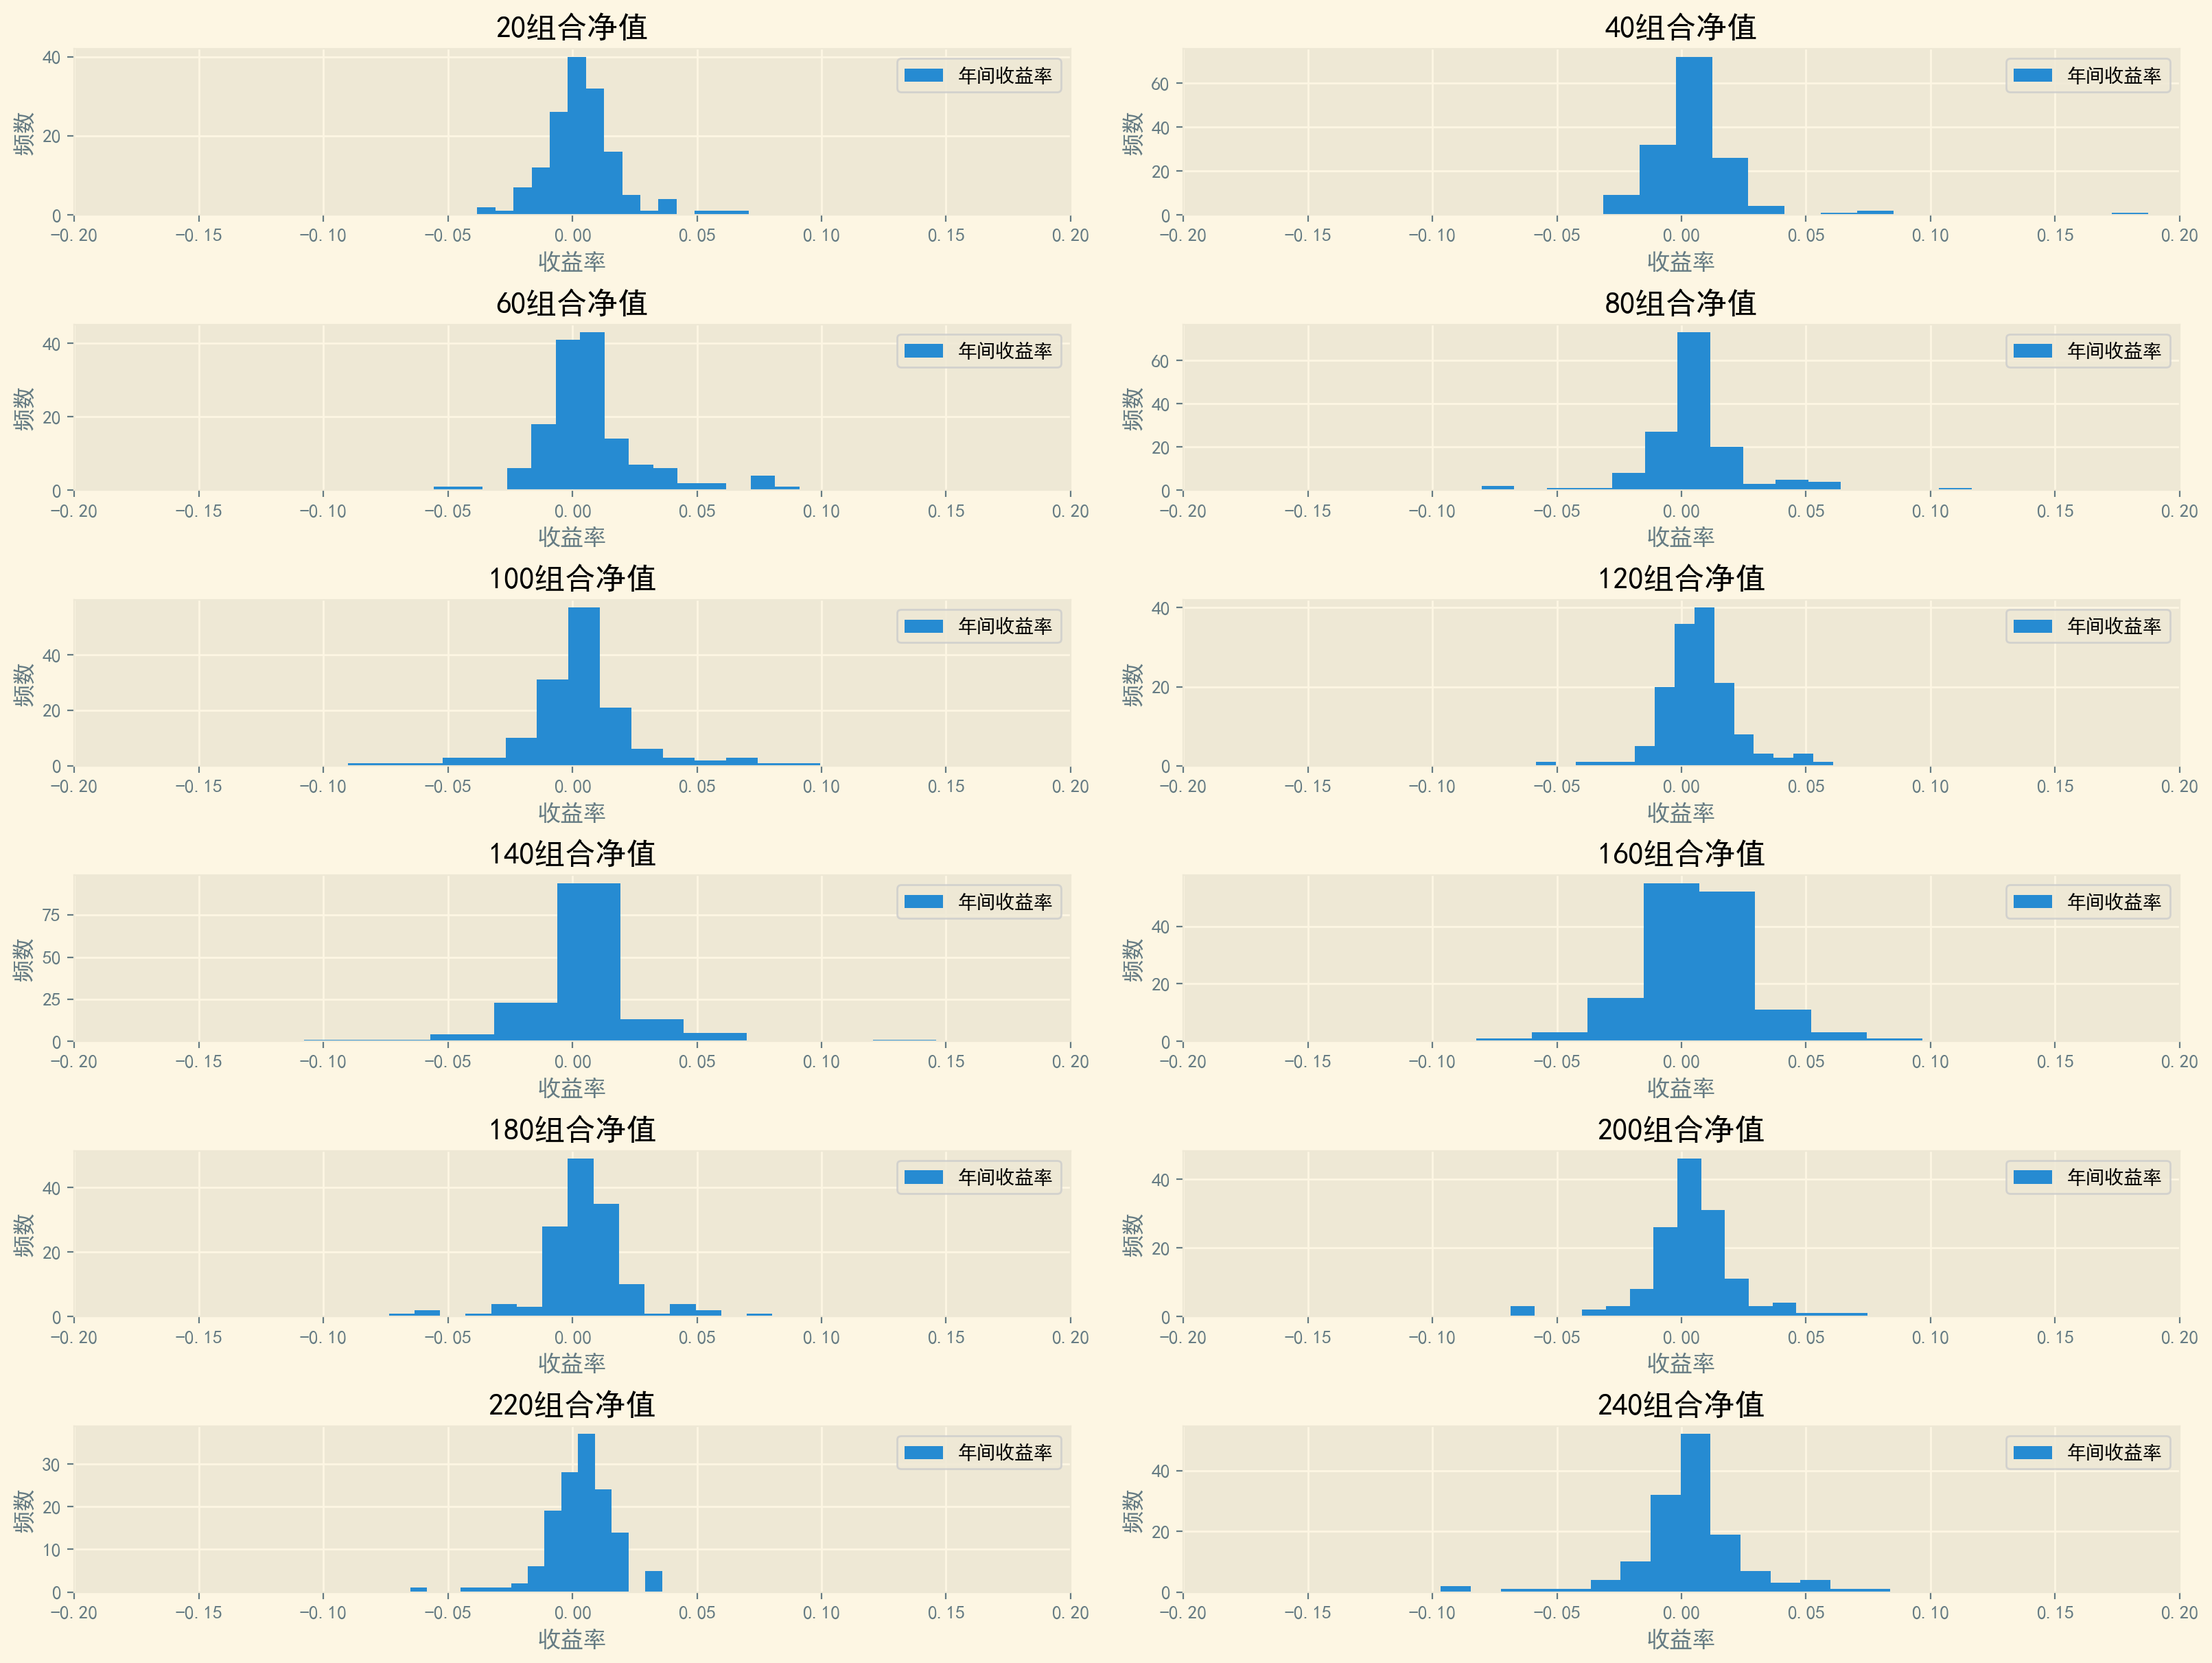

In [122]:
StatisticFunc.ReturnDist(monthlyReturns_plus, 2)

## 更多的资产标的
**新增资产明细**
- S&P500
- 10 year Treasury Bill

# 风险平价 + 因子策略 （裸权重）

## 动量因子横向比较（各资产间）

### 程序运行

In [62]:
# 运行
timeWindow = [20, 40, 60, 80, 100, 120]        # 调仓周期
ups = [0.20, 0.40, 0.60, 0.80, 1.00]           # 上调幅度
initValue = 10000

multiIDX = pd.MultiIndex.from_product([timeWindow, ups], names=['交易周期', '上调幅度'])

NetValueDF_momentumX = pd.DataFrame(index=Returns.index, columns=multiIDX)
DailyPnlDF_momentumX = pd.DataFrame(index=Returns.index, columns=multiIDX) 
DrawDownDF_momentumX = pd.DataFrame(index=Returns.index, columns=multiIDX)

In [63]:
for t in timeWindow:
    for u in ups:
        tradeDF = AlgoLoop.AlgoTrade(Returns, cumReturns, dt=t, up=u, totVal=initValue, 
                                     mode='plain', momentumX=True)

        NetValueDF_momentumX.loc[:, (t, u)] = tradeDF['投资组合净值'] / initValue  
        DailyPnlDF_momentumX.loc[:, (t, u)] = tradeDF['投资组合净值'] / tradeDF['投资组合净值'].shift(1) - 1.0
        DrawDownDF_momentumX.loc[:, (t, u)] = tradeDF['最大回撤']                      

### 回测表现汇总

In [64]:
# 汇总
summaryDF_momentumX = pd.DataFrame(index=multiIDX)

summaryDF_momentumX["年平均收益率"] = DailyPnlDF_momentumT.mean(axis=0).values * 250
summaryDF_momentumX["年平均标准差"] = DailyPnlDF_momentumT.std(axis=0).values * np.sqrt(250)
summaryDF_momentumX["无基准夏普比率"] = summaryDF_momentumT["年平均收益率"] / summaryDF_momentumT["年平均标准差"]
summaryDF_momentumX["最大回撤"] = DrawDownDF_momentumT.min(axis=0).values

summaryDF_momentumX.to_csv("横截面动量表现.csv", encoding='utf_8_sig')
summaryDF_momentumX

年平均收益率    年平均标准差   无基准夏普比率      最大回撤
交易周期 上调幅度                                        
20   0.2   0.040558  0.041784  0.970650 -0.067428
     0.4   0.041169  0.042626  0.965815 -0.070643
     0.6   0.041687  0.043661  0.954798 -0.073904
     0.8   0.042136  0.044833  0.939843 -0.079104
     1.0   0.042532  0.046107  0.922461 -0.084057
40   0.2   0.054585  0.046160  1.182516 -0.067058
     0.4   0.055778  0.047758  1.167920 -0.069301
     0.6   0.056812  0.049474  1.148314 -0.071520
     0.8   0.057725  0.051267  1.125983 -0.074619
     1.0   0.058542  0.053109  1.102314 -0.078659
60   0.2   0.047279  0.045099  1.048336 -0.095486
     0.4   0.047706  0.046156  1.033596 -0.092837
     0.6   0.048129  0.047436  1.014601 -0.091280
     0.8   0.048537  0.048876  0.993062 -0.090475
     1.0   0.048924  0.050433  0.970092 -0.091032
80   0.2   0.049325  0.050595  0.974916 -0.106107
     0.4   0.051957  0.050828  1.022197 -0.094566
     0.6   0.054398  0.051431  1.057701 -0.085606
     0.8   0.056682  0.052294  1.083896 -0.078231
     1.0   0.058829  0.053349  1.102734 -0.074430
100  0.2   0.065362  0.051681  1.264737 -0.067290
     0.4   0.067010  0.052594  1.274108 -0.067523
     0.6   0.068566  0.053727  1.276180 -0.067780
     0.8   0.070028  0.055027  1.272612 -0.074406
     1.0   0.071398  0.056452  1.264748 -0.082464
120  0.2   0.064031  0.046028  1.391111 -0.063988
     0.4   0.065363  0.047114  1.387344 -0.063402
     0.6   0.066679  0.048348  1.379143 -0.062858
     0.8   0.067960  0.049694  1.367564 -0.069904
     1.0   0.069196  0.051124  1.353489 -0.077675

### 各投资组合净值曲线

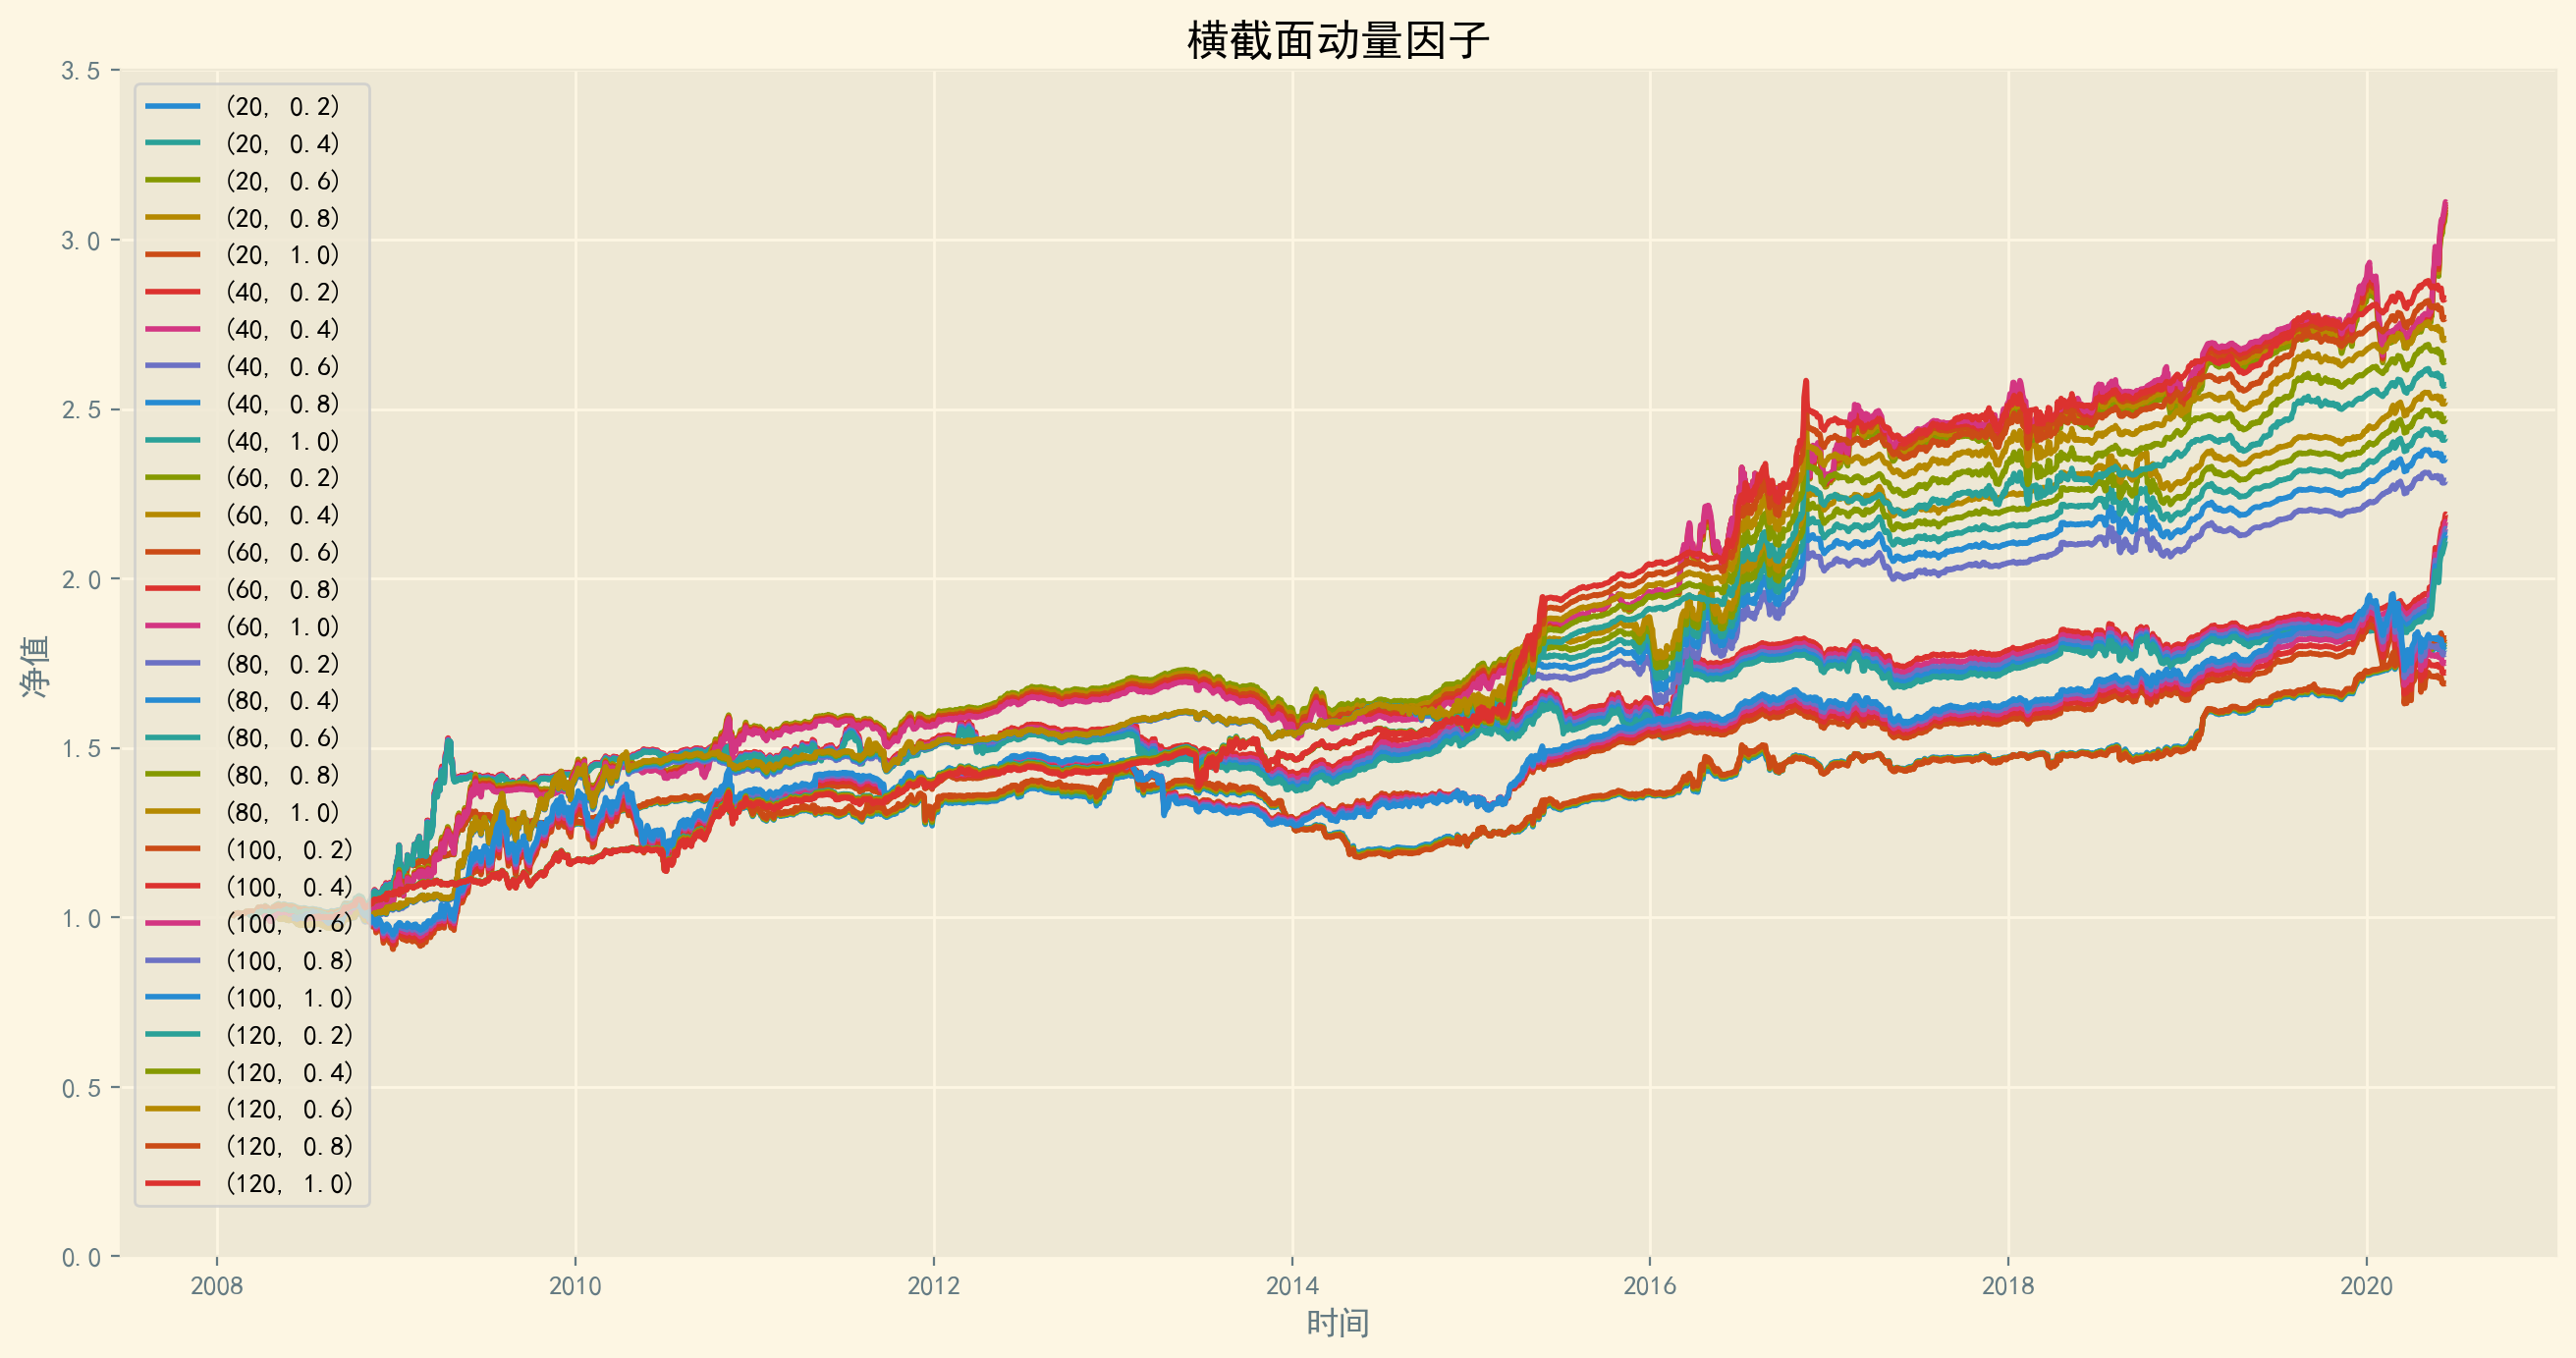

In [128]:
fig = plt.figure(figsize=(16, 8), dpi=200)

for col in NetValueDF_momentumX.columns:
    plt.plot(NetValueDF_momentumX.index, NetValueDF_momentumX[col], label=col)

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.5)
plt.legend(loc='upper left')
plt.title('横截面动量因子')
plt.savefig('横截面动量因子.jpg')

## 动量因子纵向比较（时间序列上）

### 程序运行

In [66]:
# 运行
timeWindow = [20, 40, 60, 80, 100, 120]        # 调仓周期
ups = [0.20, 0.40, 0.60, 0.80, 1.00]           # 上调幅度
initValue = 10000

multiIDX = pd.MultiIndex.from_product([timeWindow, ups], names=['交易周期', '上调幅度'])

NetValueDF_momentumT = pd.DataFrame(index=Returns.index, columns=multiIDX)
DailyPnlDF_momentumT = pd.DataFrame(index=Returns.index, columns=multiIDX) 
DrawDownDF_momentumT = pd.DataFrame(index=Returns.index, columns=multiIDX)

In [67]:
for t in timeWindow:
    for u in ups:
        tradeDF = AlgoLoop.AlgoTrade(Returns, cumReturns, dt=t, up=u, totVal=initValue, 
                                     mode='ema', momentumX=False, momentumT=True)

        NetValueDF_momentumT.loc[:, (t, u)] = tradeDF['投资组合净值'] / initValue  
        DailyPnlDF_momentumT.loc[:, (t, u)] = tradeDF['投资组合净值'] / tradeDF['投资组合净值'].shift(1) - 1.0
        DrawDownDF_momentumT.loc[:, (t, u)] = tradeDF['最大回撤']                      

### 回测表现汇总

In [68]:
# 汇总
summaryDF_momentumT = pd.DataFrame(index=multiIDX)

summaryDF_momentumT["年平均收益率"] = DailyPnlDF_momentum.mean(axis=0).values * 250
summaryDF_momentumT["年平均标准差"] = DailyPnlDF_momentum.std(axis=0).values * np.sqrt(250)
summaryDF_momentumT["无基准夏普比率"] = summaryDF_momentumX["年平均收益率"] / summaryDF_momentumX["年平均标准差"]
summaryDF_momentumT["最大回撤"] = DrawDownDF_momentum.min(axis=0).values

summaryDF_momentumT.to_csv("时间序列动量表现.csv", encoding='utf_8_sig')
summaryDF_momentumT

年平均收益率    年平均标准差   无基准夏普比率      最大回撤
交易周期 上调幅度                                        
20   0.2   0.040116  0.041514  0.970650 -0.064678
     0.4   0.040365  0.042038  0.965815 -0.065386
     0.6   0.040585  0.042699  0.954798 -0.066254
     0.8   0.040788  0.043443  0.939843 -0.067319
     1.0   0.040981  0.044239  0.922461 -0.069788
40   0.2   0.054465  0.045271  1.182516 -0.063961
     0.4   0.055438  0.046097  1.167920 -0.063402
     0.6   0.056193  0.047085  1.148314 -0.062996
     0.8   0.056792  0.048159  1.125983 -0.062697
     1.0   0.057274  0.049273  1.102314 -0.066146
60   0.2   0.046799  0.044899  1.048336 -0.102145
     0.4   0.046563  0.045700  1.033596 -0.105190
     0.6   0.046228  0.046636  1.014601 -0.108549
     0.8   0.045837  0.047636  0.993062 -0.112023
     1.0   0.045415  0.048663  0.970092 -0.115502
80   0.2   0.049266  0.051322  0.974916 -0.120708
     0.4   0.051407  0.051964  1.022197 -0.120708
     0.6   0.053092  0.052720  1.057701 -0.120708
     0.8   0.054451  0.053532  1.083896 -0.120708
     1.0   0.055567  0.054368  1.102734 -0.120708
100  0.2   0.062877  0.049692  1.264737 -0.066998
     0.4   0.062149  0.048922  1.274108 -0.066856
     0.6   0.061444  0.048546  1.276180 -0.066698
     0.8   0.060761  0.048436  1.272612 -0.066537
     1.0   0.060099  0.048507  1.264748 -0.068228
120  0.2   0.063079  0.046555  1.391111 -0.069190
     0.4   0.063382  0.048022  1.387344 -0.072871
     0.6   0.063631  0.049479  1.379143 -0.075907
     0.8   0.063833  0.050895  1.367564 -0.078455
     1.0   0.063994  0.052258  1.353489 -0.082196

### 各投资组合净值曲线

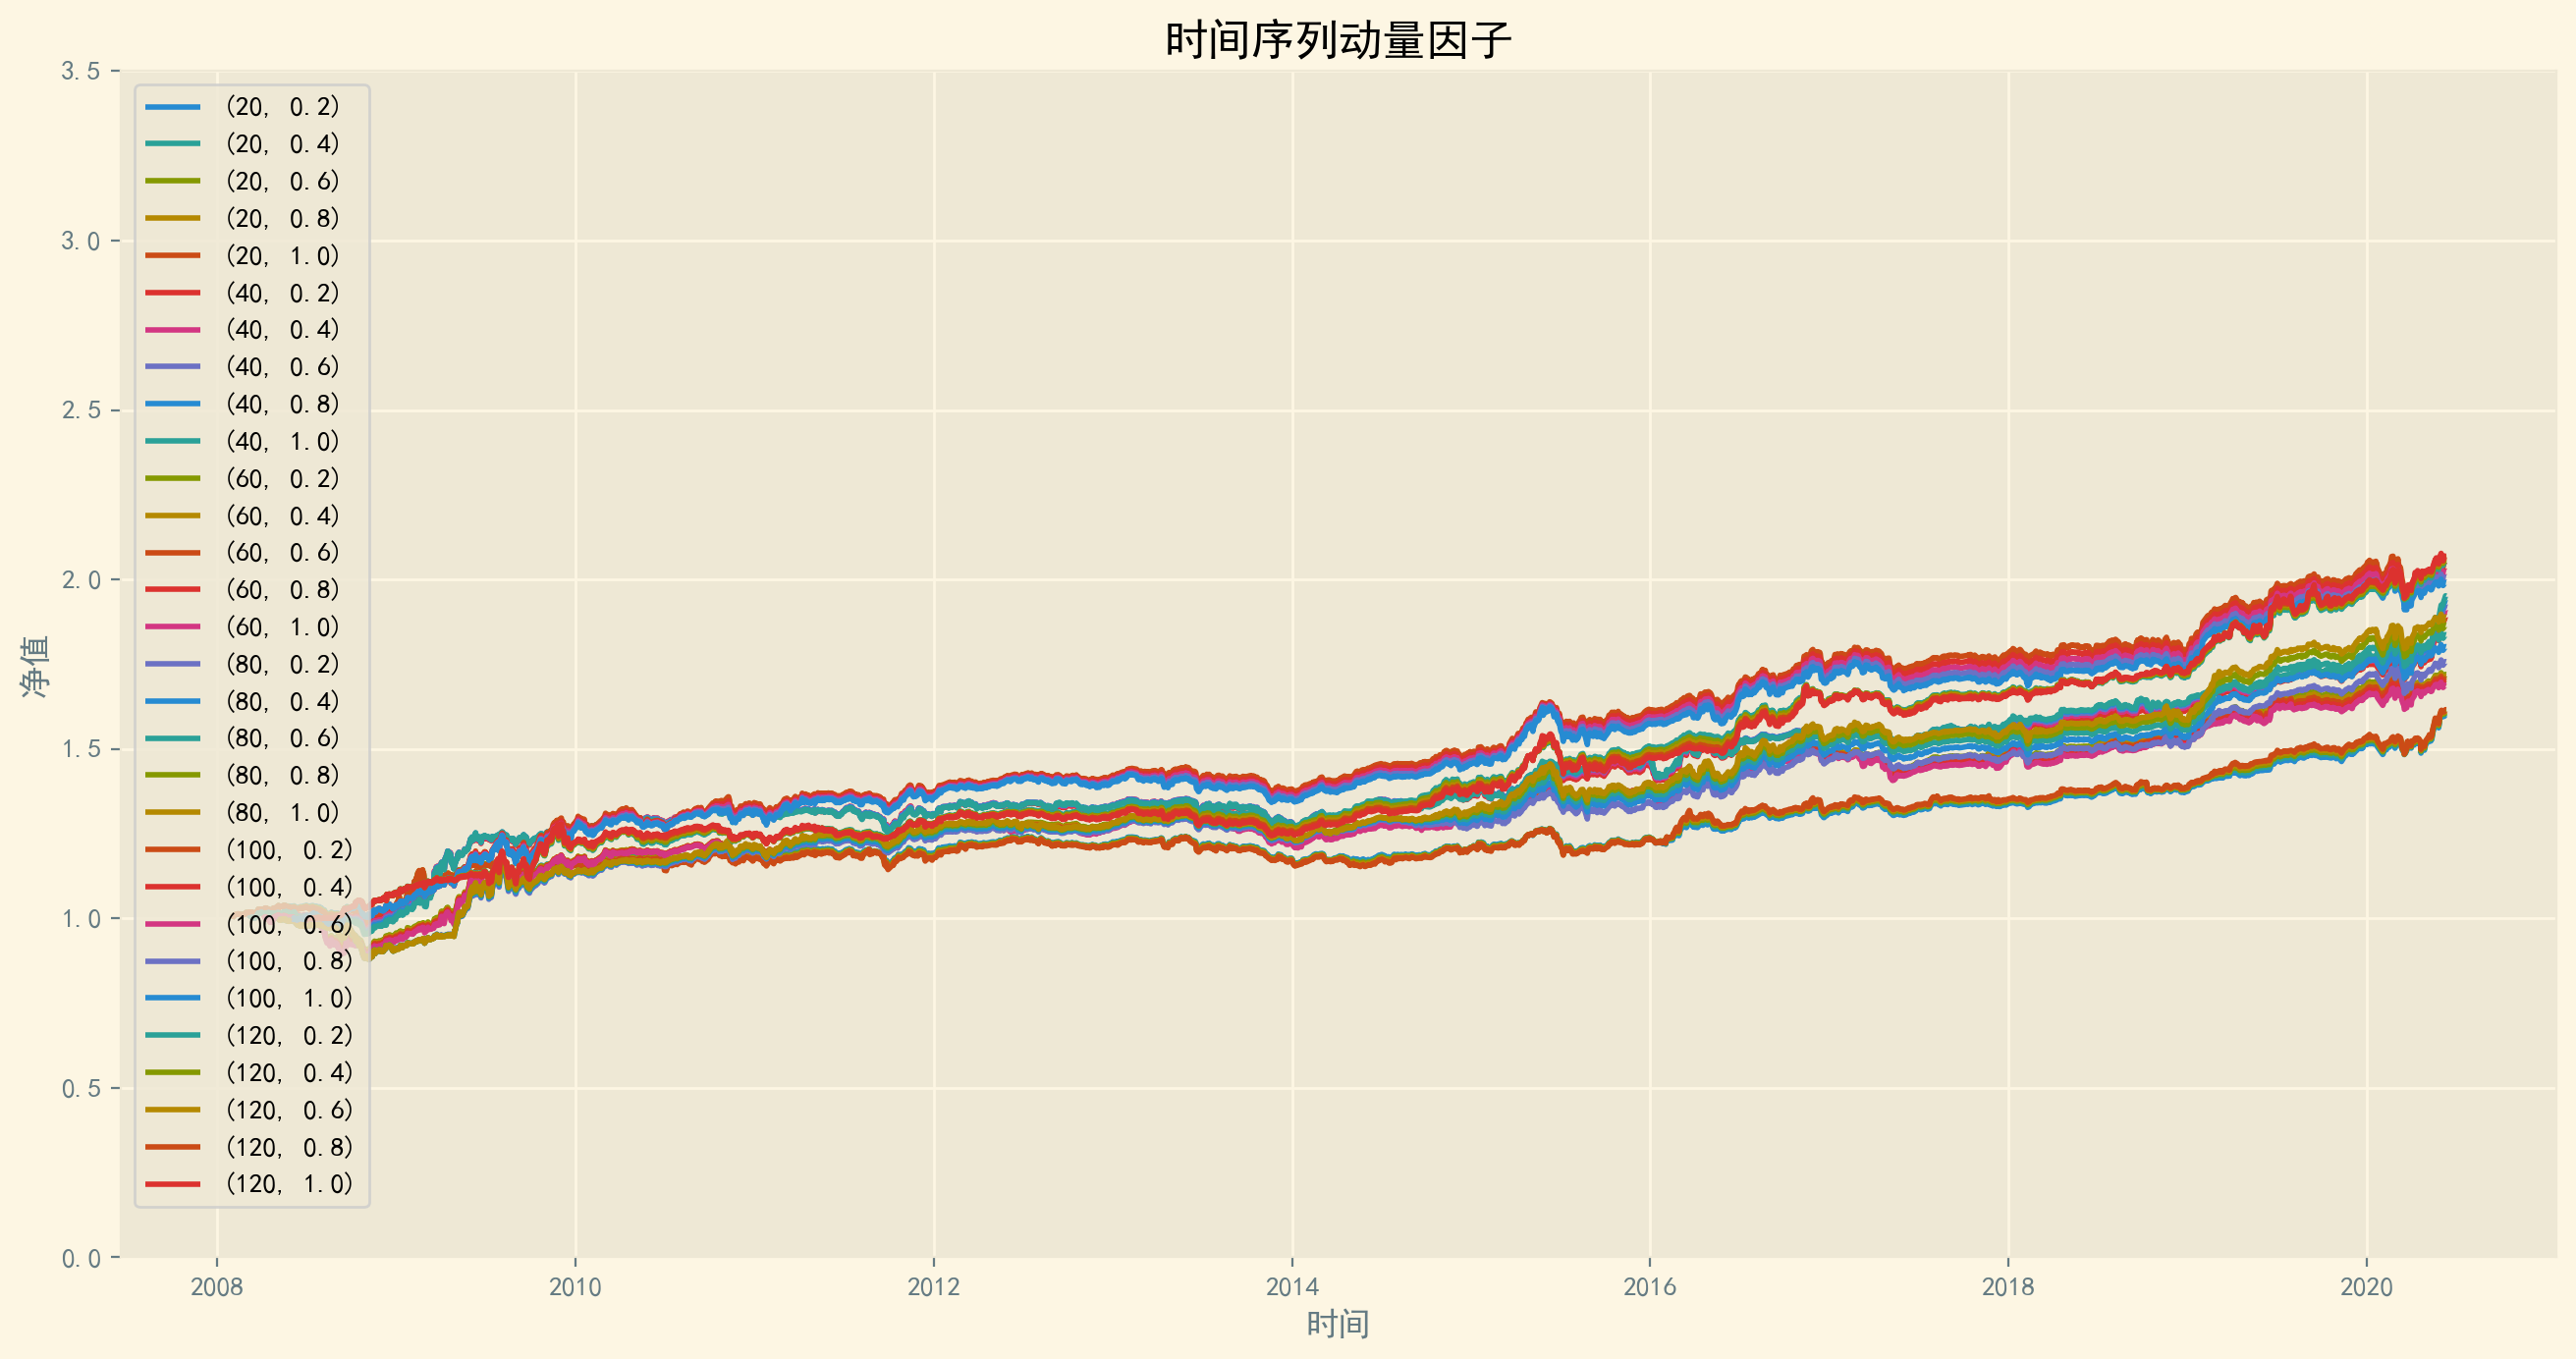

In [129]:
fig = plt.figure(figsize=(16, 8), dpi=200)

for col in NetValueDF_momentumT.columns:
    plt.plot(NetValueDF_momentumT.index, NetValueDF_momentumT[col], label=col)

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.5)
plt.legend(loc='upper left')
plt.title('时间序列动量因子')
plt.savefig('时间序列动量因子.jpg')

## 基本面因子

- PMI（超配股票和商品，低配债券）
- CPI
- 社会融资增速
- M2同比